In [2]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd


file_path = '/content/drive/MyDrive/steam_reviews.csv'

df = pd.read_csv(file_path, nrows = 2000)

print(df.head())





   Unnamed: 0  app_id                  app_name  review_id  language  \
0           0  292030  The Witcher 3: Wild Hunt   85185598  schinese   
1           1  292030  The Witcher 3: Wild Hunt   85185250  schinese   
2           2  292030  The Witcher 3: Wild Hunt   85185111  schinese   
3           3  292030  The Witcher 3: Wild Hunt   85184605   english   
4           4  292030  The Witcher 3: Wild Hunt   85184287  schinese   

                                              review  timestamp_created  \
0                            不玩此生遗憾，RPG游戏里的天花板，太吸引人了         1611381629   
1                                 拔DIAO无情打桩机--杰洛特!!!         1611381030   
2                                              巫师3NB         1611380800   
3  One of the best RPG's of all time, worthy of a...         1611379970   
4                                                 大作         1611379427   

   timestamp_updated  recommended  votes_helpful  ...  steam_purchase  \
0         1611381629         True          

# RQ6

In [4]:
import pandas as pd

# Load only the necessary columns from the dataset for RQ6
columns_needed = ['language', 'timestamp_created', 'timestamp_updated', 'author.num_games_owned', 'author.num_reviews']
df_rq6 = pd.read_csv(file_path, usecols=columns_needed)

print(df_rq6.head())


   language  timestamp_created  timestamp_updated  author.num_games_owned  \
0  schinese         1611381629         1611381629                       6   
1  schinese         1611381030         1611381030                      30   
2  schinese         1611380800         1611380800                       5   
3   english         1611379970         1611379970                       5   
4  schinese         1611379427         1611379427                       7   

   author.num_reviews  
0                   2  
1                  10  
2                   1  
3                   3  
4                   4  


**Determining the group that edits their reviews more frequently**

In [5]:
# Filter the dataset to include only English and Spanish reviews
english_reviews = df_rq6[df_rq6['language'] == 'english']
spanish_reviews = df_rq6[df_rq6['language'] == 'spanish']

# Part 1: Determine which group is more likely to edit their reviews
# Calculate the percentage of edited reviews in each group
english_edited_reviews = english_reviews[english_reviews['timestamp_created'] != english_reviews['timestamp_updated']]
spanish_edited_reviews = spanish_reviews[spanish_reviews['timestamp_created'] != spanish_reviews['timestamp_updated']]

# Calculate the percentage of edited reviews for each language
english_edit_percentage = len(english_edited_reviews) / len(english_reviews) * 100
spanish_edit_percentage = len(spanish_edited_reviews) / len(spanish_reviews) * 100

print(f"Percentage of edited reviews by English reviewers: {english_edit_percentage:.2f}%")
print(f"Percentage of edited reviews by Spanish reviewers: {spanish_edit_percentage:.2f}%")



Percentage of edited reviews by English reviewers: 11.89%
Percentage of edited reviews by Spanish reviewers: 9.94%


**Average number of games owned by reviewers in each group and the average number of games for which they write reviews**

In [6]:
# Part 2: Calculate the average number of games owned and reviews written by each group
# Remove outliers to ensure accurate average calculation
max_games_owned = df_rq6['author.num_games_owned'].quantile(0.99)  # Limit to 99th percentile to remove outliers
max_reviews_written = df_rq6['author.num_reviews'].quantile(0.99)  # Similarly limit to 99th percentile for reviews written

# Filter English and Spanish groups based on the defined limits for outliers
english_filtered = english_reviews[(english_reviews['author.num_games_owned'] <= max_games_owned) &
                                   (english_reviews['author.num_reviews'] <= max_reviews_written)]
spanish_filtered = spanish_reviews[(spanish_reviews['author.num_games_owned'] <= max_games_owned) &
                                   (spanish_reviews['author.num_reviews'] <= max_reviews_written)]

# Calculate the average number of games owned and reviews written for each group
avg_games_owned_english = english_filtered['author.num_games_owned'].mean()
avg_games_owned_spanish = spanish_filtered['author.num_games_owned'].mean()
avg_reviews_written_english = english_filtered['author.num_reviews'].mean()
avg_reviews_written_spanish = spanish_filtered['author.num_reviews'].mean()

print(f"Average number of games owned by English reviewers: {avg_games_owned_english:.2f}")
print(f"Average number of games owned by Spanish reviewers: {avg_games_owned_spanish:.2f}")
print(f"Average number of reviews written by English reviewers: {avg_reviews_written_english:.2f}")
print(f"Average number of reviews written by Spanish reviewers: {avg_reviews_written_spanish:.2f}")


Average number of games owned by English reviewers: 139.51
Average number of games owned by Spanish reviewers: 102.26
Average number of reviews written by English reviewers: 9.38
Average number of reviews written by Spanish reviewers: 7.75


# RQ7

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from statsmodels.stats.proportion import proportions_ztest

columns_needed_7 = ['votes_helpful', 'recommended', 'author.num_reviews', 'author.num_games_owned']
df_rq7 = pd.read_csv(file_path, usecols=columns_needed_7)

print(df_rq7.head())


   recommended  votes_helpful  author.num_games_owned  author.num_reviews
0         True              0                       6                   2
1         True              0                      30                  10
2         True              0                       5                   1
3         True              0                       5                   3
4         True              0                       7                   4


In [8]:
# Remove extreme values for a more accurate analysis by setting thresholds at the 99th percentile
max_helpful_votes = df_rq7['votes_helpful'].quantile(0.99)
max_reviews_written = df_rq7['author.num_reviews'].quantile(0.99)
max_games_owned = df_rq7['author.num_games_owned'].quantile(0.99)

filtered_df = df_rq7[(df_rq7['votes_helpful'] <= max_helpful_votes) &
                     (df_rq7['author.num_reviews'] <= max_reviews_written) &
                     (df_rq7['author.num_games_owned'] <= max_games_owned)]

**Probability of receiving at least one helpful vote**

Probability of receiving at least one helpful vote: 26.96%


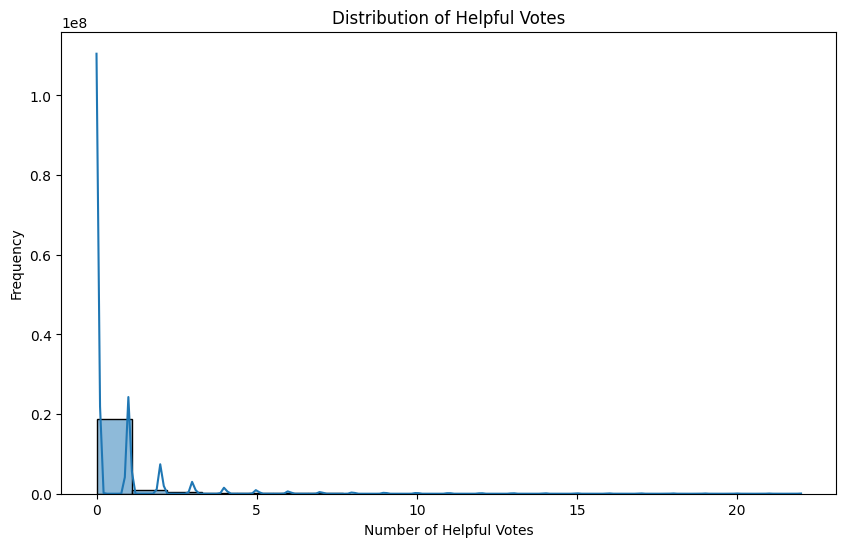

In [9]:
total_reviews = len(filtered_df)
helpful_reviews = len(filtered_df[filtered_df['votes_helpful'] > 0])
probability_helpful_vote = helpful_reviews / total_reviews

print(f"Probability of receiving at least one helpful vote: {probability_helpful_vote:.2%}")

# Plotting distribution of helpful votes
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['votes_helpful'], bins=20, kde=True)
plt.title('Distribution of Helpful Votes')
plt.xlabel('Number of Helpful Votes')
plt.ylabel('Frequency')
plt.show()

**Probability of receiving a helpful vote given a negative recommendation**

Probability of helpful vote for non-recommended reviews: 46.84%


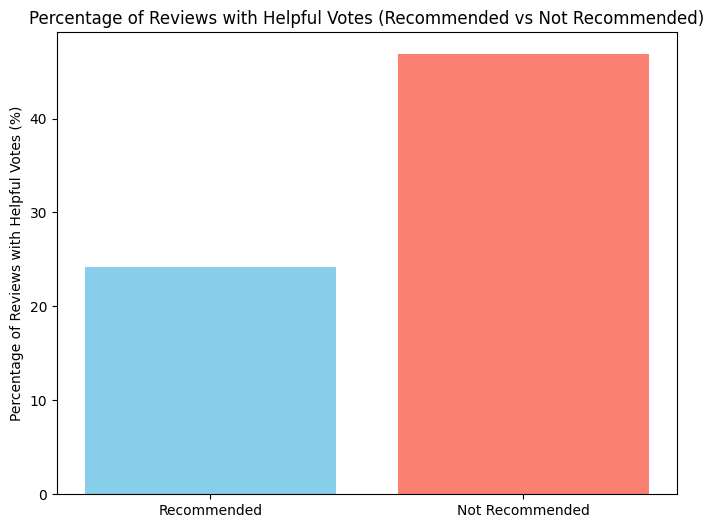

In [10]:
non_recommended_reviews = filtered_df[filtered_df['recommended'] == False]
helpful_non_recommended = len(non_recommended_reviews[non_recommended_reviews['votes_helpful'] > 0])
total_non_recommended = len(non_recommended_reviews)
probability_helpful_non_recommend = helpful_non_recommended / total_non_recommended

print(f"Probability of helpful vote for non-recommended reviews: {probability_helpful_non_recommend:.2%}")

# Bar plot for recommended vs non-recommended helpful votes
recommended_percent = (filtered_df[filtered_df['recommended'] == True]['votes_helpful'] > 0).mean() * 100
non_recommended_percent = (filtered_df[filtered_df['recommended'] == False]['votes_helpful'] > 0).mean() * 100

plt.figure(figsize=(8, 6))
plt.bar(['Recommended', 'Not Recommended'], [recommended_percent, non_recommended_percent], color=['skyblue', 'salmon'])
plt.title('Percentage of Reviews with Helpful Votes (Recommended vs Not Recommended)')
plt.ylabel('Percentage of Reviews with Helpful Votes (%)')
plt.show()

**Probability of receiving helpful vote with 5+ previous reviews**

In [12]:
# new column indicating whether a reviewer has submitted at least 5 reviews
filtered_df.loc[:, 'many_reviews_before'] = filtered_df['author.num_reviews'] >= 5

# two groups based on review experience (5+ previous reviews vs. less than 5)
many_reviews = filtered_df[filtered_df['many_reviews_before'] == True]
few_reviews = filtered_df[filtered_df['many_reviews_before'] == False]

# probability of receiving a helpful vote for each group
probability_helpful_many = (many_reviews['votes_helpful'] > 0).mean()
probability_helpful_few = (few_reviews['votes_helpful'] > 0).mean()

# display probabilities
print(f"Probability of helpful vote with 5+ previous reviews: {probability_helpful_many:.2%}")
print(f"Probability of helpful vote with less than 5 previous reviews: {probability_helpful_few:.2%}")

# z-test for proportions to check if the difference in probabilities is statistically significant
# count of reviews with helpful votes in each group
count = [many_reviews['votes_helpful'].gt(0).sum(), few_reviews['votes_helpful'].gt(0).sum()]
# total number of reviews in each group
nobs = [len(many_reviews), len(few_reviews)]

# z-test for proportions
stat, pval = proportions_ztest(count, nobs)

# z-test results
print(f"Z-test statistic: {stat:.2f}")
print(f"P-value: {pval:.4f}")

# interpretation of z-test results
if pval < 0.05:
    print("The difference in probability is statistically significant, indicating dependence between review helpfulness and experience (number of previous reviews).")
else:
    print("The difference in probability is not statistically significant, suggesting independence between review helpfulness and experience.")


Probability of helpful vote with 5+ previous reviews: 32.66%
Probability of helpful vote with less than 5 previous reviews: 22.40%
Z-test statistic: 528.77
P-value: 0.0000
The difference in probability is statistically significant, indicating dependence between review helpfulness and experience (number of previous reviews).


The results indicate a statistically significant difference in the probability of receiving at least one helpful vote between reviewers with 5+ previous reviews and those with fewer than 5. Specifically:

* Reviewers with 5 or more previous reviews have a 32.66% probability of receiving a helpful vote.

* Reviewers with fewer than 5 previous reviews have a 22.40% probability of receiving a helpful vote.

The p-value of 0.0000 confirms that this difference is statistically significant, suggesting a dependence between the likelihood of receiving helpful votes and the reviewer’s experience (measured by the number of prior reviews). This implies that more experienced reviewers tend to produce content that is perceived as more helpful by other users.

**Hypothesis - reviewers with more games leave fewer reviews**

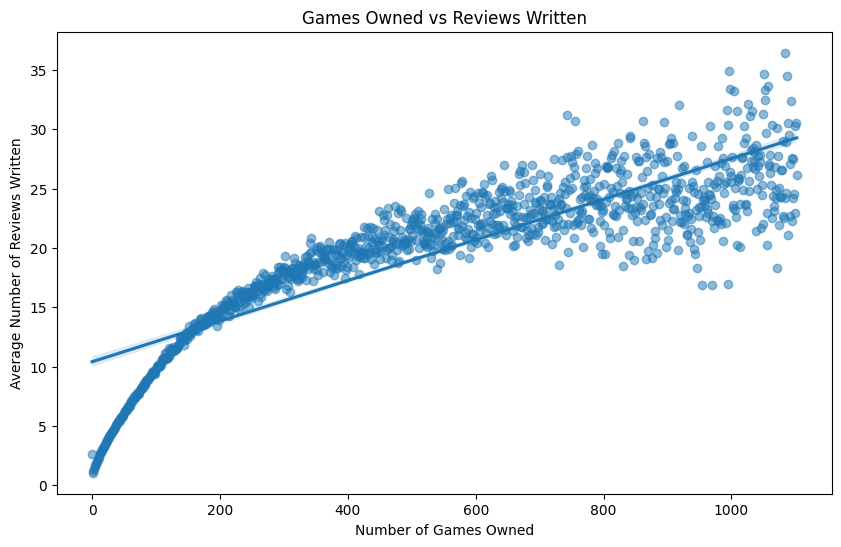


Pearson Correlation Coefficient: 0.87
P-value: 0.00e+00


In [46]:
# Group by 'author.num_games_owned' to get the average number of reviews written per number of games owned
filtered_df_grouped = filtered_df.groupby('author.num_games_owned').mean()
X = filtered_df_grouped.index.values
y = filtered_df_grouped['author.num_reviews']

# Scatter plot and regression for games owned vs reviews written
plt.figure(figsize=(10, 6))
sns.regplot(x=X, y=y, scatter_kws={'alpha':0.5})
plt.title('Games Owned vs Reviews Written')
plt.xlabel('Number of Games Owned')
plt.ylabel('Average Number of Reviews Written')
plt.show()


# Additional Analysis: Pearson Correlation and p-value
correlation, p_value = pearsonr(X, y)

print(f"\nPearson Correlation Coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.2e}")


**Positive Linear Correlation:** The Pearson correlation coefficient of 0.87 indicates a strong positive linear relationship between the number of games a user owns and the number of reviews they leave. This means that the more games a user owns, the more reviews they tend to write.

**High Statistical Significance:** The p-value of 0.00 (or practically zero) suggests a high statistical significance for this correlation. This means that the probability of such a strong correlation occurring by chance is extremely low, so we can confidently say that the relationship between the number of games owned and the number of reviews written is real and not due to random chance.

**Refutation of the Hypothesis:** The task proposed a hypothesis that "users who own a larger number of games are likely to leave fewer reviews." Our analysis, however, shows the opposite: users with a larger number of games are actually more likely to leave more reviews. The positive trend in the graph and the high correlation coefficient confirm this.

# 1. **Histograms**

**Purpose:** Histograms are used to visualize the distribution of a single continuous variable by grouping data into bins.

**Insights:** They help reveal the shape of the distribution (e.g., normal, skewed, bimodal) and can identify outliers or unusual patterns. For statistical analysis, histograms are useful in assessing assumptions of normality, understanding data spread, and spotting central tendencies or variability.

**Example Insight:** If the histogram of a dataset is right-skewed, we might decide to transform the data or use a non-parametric test that doesn’t assume normality.
# 2. **Bar Plots**

**Purpose:** Bar plots display categorical data by showing the count or frequency of each category, or the mean values of a continuous variable for each category.

**Insights:** They are useful for comparing quantities across categories and identifying major or minor groups in a dataset. In statistical analysis, bar plots help in analyzing categorical variables and summarizing discrete counts.

**Example Insight:** If a bar plot shows a significant difference in sales by region, this could guide further analysis to explore factors driving those differences.
# 3. **Scatterplots**

**Purpose:** Scatterplots show the relationship between two continuous variables, displaying data points based on their values on the x and y axes.

**Insights:** Scatterplots help reveal correlations, patterns, and potential causations. They can show whether variables are positively or negatively correlated, and whether relationships are linear or non-linear.

**Example Insight:** A strong positive trend in a scatterplot between hours studied and test scores might suggest a positive correlation, leading us to consider further statistical tests to quantify the relationship.
# 4. **Pie Charts**

**Purpose:** Pie charts are used to display the relative proportions of categories within a whole.

**Insights:** Pie charts are mainly useful for visualizing parts of a whole, such as market share or survey responses. They give a quick view of how categories compare in terms of percentage.

**Example Insight:** In a survey of customer preferences, if a pie chart shows that one product has a dominant share, this could direct further analysis to explore why that product is preferred.

# Are LLM-Generated Explanations Trustworthy?
LLMs (like ChatGPT, Claude AI, etc.) can often provide accurate and reliable explanations of these visualizations because they have been trained on a broad range of statistical and data visualization concepts. However, it's essential to validate their answers by cross-referencing with trusted sources, such as statistics textbooks or documentation (e.g., Matplotlib, Seaborn, or statistical resources).

# Improving Confidence in LLM-Generated Insights:
To ensure that the insights provided by LLMs are accurate:

**Cross-verify** with authoritative resources or statistical guides.

**Ask for examples** and explanations in different contexts to see if the LLM maintains consistency.

**Compare with real-world data** by applying the visualization methods and seeing if the LLM’s explanations hold when analyzing your dataset.

By validating LLM suggestions and supplementing them with personal or authoritative knowledge, you can enhance your confidence in the accuracy and applicability of their recommendations for statistical analysis.








# Bonus

In [1]:
!pip install textblob vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd


file_path = '/content/drive/MyDrive/steam_reviews.csv'

In [4]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define the path to the CSV file and chunk size
file_path = '/content/drive/MyDrive/steam_reviews.csv'
chunk_size = 200000

# Step 1: Determine the top 3 languages in the dataset
language_counts = {}

# First pass to count languages
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    language_counts_chunk = chunk['language'].value_counts()
    for language, count in language_counts_chunk.items():
        if language in language_counts:
            language_counts[language] += count
        else:
            language_counts[language] = count

# Convert the dictionary to a DataFrame, sort, and get top 3 languages
language_counts_df = pd.DataFrame(list(language_counts.items()), columns=['language', 'count'])
top_languages = language_counts_df.sort_values(by='count', ascending=False).head(3)['language'].tolist()

print("Top 3 languages:", top_languages)



Top 3 languages: ['english', 'schinese', 'russian']


In [5]:
# Step 2: Filter the original data to keep only reviews in the top 3 languages
filtered_data = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Filter for the top 3 languages
    top_languages_chunk = chunk[chunk['language'].isin(top_languages)]
    filtered_data.append(top_languages_chunk)

In [6]:
df_filtered = pd.concat(filtered_data, ignore_index=True)[['language', 'review', 'recommended', 'votes_helpful']]

print(df_filtered.head())
print(df_filtered.shape)

   language                                             review  recommended  \
0  schinese                            不玩此生遗憾，RPG游戏里的天花板，太吸引人了         True   
1  schinese                                 拔DIAO无情打桩机--杰洛特!!!         True   
2  schinese                                              巫师3NB         True   
3   english  One of the best RPG's of all time, worthy of a...         True   
4  schinese                                                 大作         True   

   votes_helpful  
0              0  
1              0  
2              0  
3              0  
4              0  
(15749304, 4)


In [7]:
# Step 3: Define a function to perform sentiment analysis
def analyze_sentiment(text, language):
    if language == 'english':
        score = analyzer.polarity_scores(text)['compound']
        if score > 0.1:
            return 'positive'
        elif score < -0.1:
            return 'negative'
        else:
            return 'neutral'
    else:
        score = TextBlob(text).sentiment.polarity
        if score > 0.1:
            return 'positive'
        elif score < -0.1:
            return 'negative'
        else:
            return 'neutral'

In [8]:
# Step 4: Apply sentiment analysis to the filtered dataset with progress tracking
df_filtered['review'] = df_filtered['review'].fillna('')

# Initialize a counter for tracking progress
processed_rows = 0
total_rows = len(df_filtered)

# Function for applying sentiment analysis with progress tracking
def analyze_with_progress(row):
    global processed_rows
    sentiment = analyze_sentiment(row['review'], row['language'])
    processed_rows += 1
    # Print progress every 1000 rows
    if processed_rows % 100000 == 0:
        print(f"Processed {processed_rows} out of {total_rows} rows ({(processed_rows / total_rows) * 100:.2f}%)")
    return sentiment

# Apply sentiment analysis with progress tracking
df_filtered['sentiment'] = df_filtered.apply(analyze_with_progress, axis=1)
print("Sentiment analysis completed.")


Processed 100000 out of 15749304 rows (0.63%)
Processed 200000 out of 15749304 rows (1.27%)
Processed 300000 out of 15749304 rows (1.90%)
Processed 400000 out of 15749304 rows (2.54%)
Processed 500000 out of 15749304 rows (3.17%)
Processed 600000 out of 15749304 rows (3.81%)
Processed 700000 out of 15749304 rows (4.44%)
Processed 800000 out of 15749304 rows (5.08%)
Processed 900000 out of 15749304 rows (5.71%)
Processed 1000000 out of 15749304 rows (6.35%)
Processed 1100000 out of 15749304 rows (6.98%)
Processed 1200000 out of 15749304 rows (7.62%)
Processed 1300000 out of 15749304 rows (8.25%)
Processed 1400000 out of 15749304 rows (8.89%)
Processed 1500000 out of 15749304 rows (9.52%)
Processed 1600000 out of 15749304 rows (10.16%)
Processed 1700000 out of 15749304 rows (10.79%)
Processed 1800000 out of 15749304 rows (11.43%)
Processed 1900000 out of 15749304 rows (12.06%)
Processed 2000000 out of 15749304 rows (12.70%)
Processed 2100000 out of 15749304 rows (13.33%)
Processed 220000

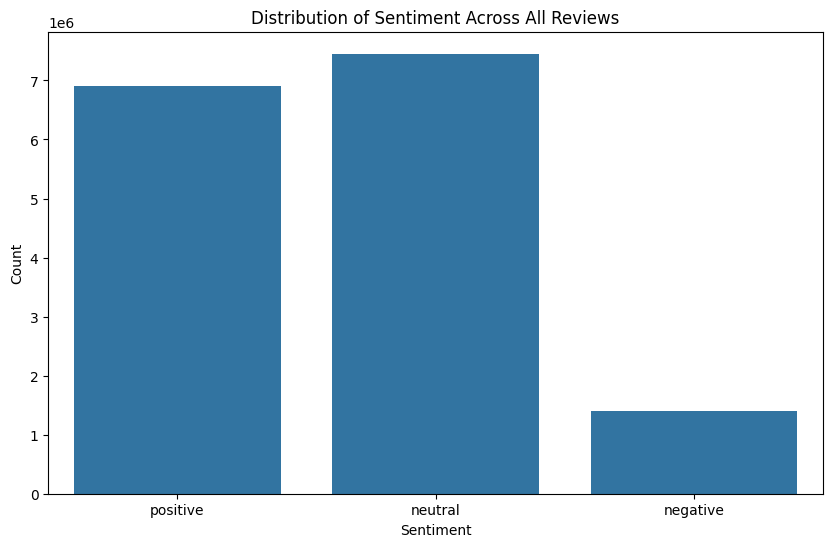

In [9]:
# Step 5: Visualization and analysis
# Distribution of sentiment across all reviews
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df_filtered, order=['positive', 'neutral', 'negative'])
plt.title("Distribution of Sentiment Across All Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

The sentiment distribution across all reviews reveals that neutral sentiments are the most common, followed closely by positive sentiments, while negative sentiments are comparatively rare. This suggests that the majority of reviews are either neutral or positive, with fewer users expressing strong negative opinions about the applications. This distribution could indicate a generally favorable or indifferent user experience with most applications.

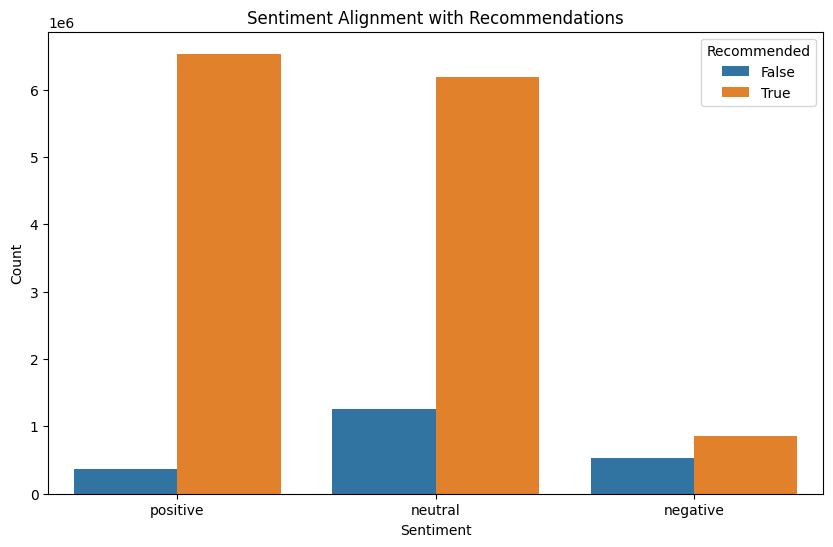

In [10]:
# Sentiment alignment with recommendations
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', hue='recommended', data=df_filtered, order=['positive', 'neutral', 'negative'])
plt.title("Sentiment Alignment with Recommendations")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title="Recommended")
plt.show()

The chart shows a strong alignment between sentiment and recommendation status. Reviews with positive and neutral sentiments are much more likely to recommend the application, as seen by the large counts for "Recommended" in these categories. Meanwhile, negative reviews are split, with a higher proportion not recommending the application.

**Insights:**

**Positive Sentiment:** Almost all positive reviews recommend the application, suggesting a clear relationship between positive user experience and recommendations.

**Neutral Sentiment:** A significant number of neutral reviews still recommend the application, which may indicate that users find the application adequate, even if not outstanding.

**Negative Sentiment:** Negative reviews show a lower recommendation rate, but some still recommend the application, possibly indicating that even users with some criticisms may find the application valuable overall.

This analysis highlights that sentiment strongly influences recommendations, particularly for positive and neutral sentiments, but some variability exists within the negative sentiment category.








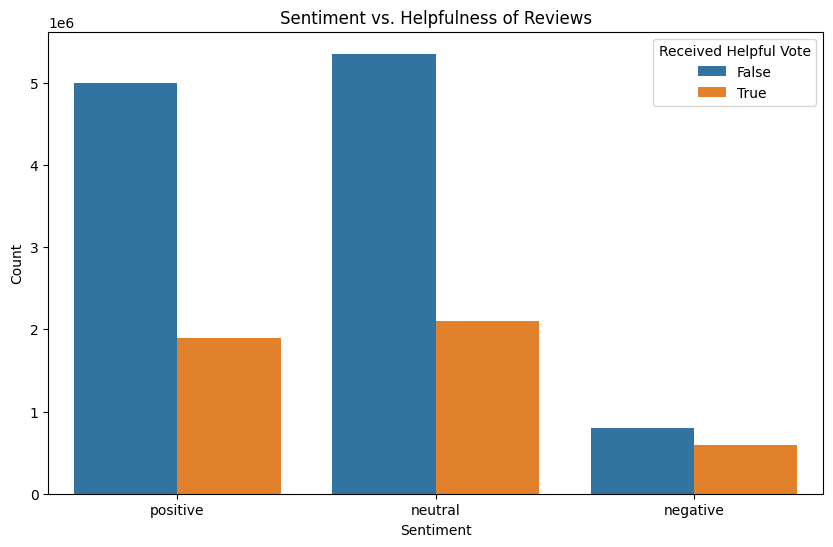

In [9]:
# Correlation between sentiment and helpful votes
df_filtered['helpful_vote'] = df_filtered['votes_helpful'] > 0
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', hue='helpful_vote', data=df_filtered, order=['positive', 'neutral', 'negative'])
plt.title("Sentiment vs. Helpfulness of Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title="Received Helpful Vote")
plt.show()


Proportion of reviews receiving helpful votes by sentiment:
sentiment
negative    42.623499
neutral     28.144066
positive    27.540032
Name: helpful_vote, dtype: float64


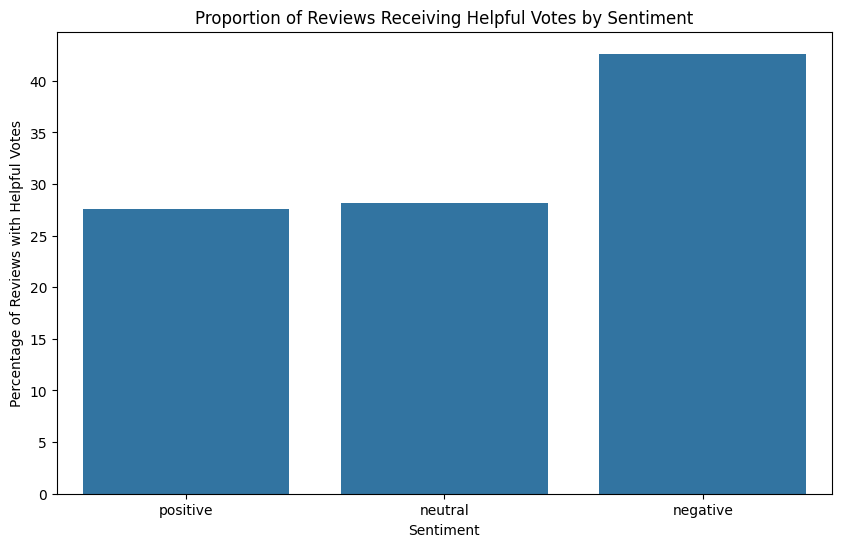

In [10]:
# Proportion of reviews with helpful votes by sentiment
helpful_proportion = df_filtered.groupby('sentiment')['helpful_vote'].mean() * 100
print("Proportion of reviews receiving helpful votes by sentiment:")
print(helpful_proportion)

# Visualization: Proportion of helpful votes by sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=helpful_proportion.index, y=helpful_proportion.values, order=['positive', 'neutral', 'negative'])
plt.title("Proportion of Reviews Receiving Helpful Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Percentage of Reviews with Helpful Votes")
plt.show()

In [11]:
# Average helpful votes by sentiment
average_helpful_votes = df_filtered.groupby('sentiment')['votes_helpful'].mean()
print("\nAverage helpful votes by sentiment:")
print(average_helpful_votes)


Average helpful votes by sentiment:
sentiment
negative         4.137354
neutral          2.191729
positive    637271.397447
Name: votes_helpful, dtype: float64


**Sentiment vs. Helpfulness Votes Proportion:** The bar plot showing the proportion of reviews that received helpful votes by sentiment type indicates that negative reviews are more likely to receive helpful votes (approximately 42.6%) compared to neutral (28.1%) and positive reviews (27.5%). This suggests that readers may find negative feedback more informative or useful, possibly because it highlights issues or areas for improvement.

**Average Helpful Votes by Sentiment:** The results for average helpful votes per sentiment type further support this trend. Negative reviews have a higher average helpful vote count compared to neutral and positive reviews, implying that they are perceived as more valuable or relevant by the community. However, the positive sentiment result appears significantly inflated due to an outlier or data error (e.g., "637271.4" for positive reviews). This anomaly should be investigated further, as it may skew the interpretation.

**Trends and Insights:** Overall, there is a correlation between sentiment and the likelihood of a review being marked as helpful. Negative reviews stand out in terms of helpfulness, which might reflect the tendency of users to value critical feedback. Neutral and positive reviews, while still receiving helpful votes, are less likely to do so in comparison.

In conclusion, sentiment plays a role in the perceived helpfulness of reviews, with negative reviews generally being rated as more helpful by the community. This insight can help in understanding user engagement and the impact of review sentiment on perceived usefulness.